# Projeto ‚Äî GeoGuardian

**FIAP** ‚Äî _Faculdade de Inform√°tica e Administra√ß√£o Paulista_  
**Mat√©ria:** _Disruptive Architectures: IoT, IoB & Generative AI_  
**Turma:** _2TDSPW_  
**Professor:** _Alberto Messias_

## **Integrantes**

- Cau√£ Marcelo Machado ‚Äî _RM 558024_
- Gabriel Lima Silva ‚Äî _RM 556773_
- Felipe Melo de Sousa ‚Äî _RM 556099_

# **Fase 1 ‚Äî Setup e Bibliotecas**

In [13]:
# Instala√ß√£o do pacote xgboost
!pip install xgboost -q

# Importa√ß√£o das bibliotecas necess√°rias
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

# Configura√ß√£o do tema dos gr√°ficos
sns.set_theme(style="whitegrid")

# **Fase 2 - Gera√ß√£o do Dataset Simulado**

In [14]:
# Listas fixas para locais e status de risco
locais = ["Morro Azul", "Encosta Verde", "Vale Seguro", "Colina Alta", "Serra Branca"]
status_risco = ["Baixo", "M√©dio", "Alto"]

# Fun√ß√£o para gerar dados simulados de sensores
def gerar_dados_sensor():
    local = random.choice(locais)
    latitude = round(random.uniform(-23.5, -23.0), 6)
    longitude = round(random.uniform(-46.8, -46.3), 6)

    temperatura = round(random.uniform(15, 40), 2)
    umidade = round(random.uniform(20, 100), 2)
    vibracao = round(random.uniform(0, 10), 2)
    qualidade_solo = round(random.uniform(0, 100), 2)

    # Define n√≠vel de risco com base nos valores de vibra√ß√£o e qualidade do solo
    if vibracao > 7 or qualidade_solo < 30:
        risco = "Alto"
    elif vibracao > 4 or qualidade_solo < 50:
        risco = "M√©dio"
    else:
        risco = "Baixo"

    # Data do registro aleat√≥ria nos √∫ltimos 90 dias
    data_registro = (datetime.today() - timedelta(days=random.randint(0, 90))).strftime("%Y-%m-%d")

    return (local, latitude, longitude, temperatura, umidade, vibracao, qualidade_solo, risco, data_registro)

# N√∫mero de registros a serem gerados
n = 5000
data = []

# Loop para gerar os dados e montar lista para DataFrame
for i in range(1, n + 1):
    dados = gerar_dados_sensor()
    data.append([f"SENSOR-{i:05d}", *dados])

# Cria√ß√£o do DataFrame com colunas nomeadas
df = pd.DataFrame(data, columns=[
    "SensorID", "Local", "Latitude", "Longitude", "Temperatura",
    "Umidade", "Vibracao", "Qualidade_Solo", "Risco", "Data_Registro"
])

df.head()

SensorID        Local   Latitude  Longitude  Temperatura  Umidade  \
0  SENSOR-00001  Colina Alta -23.438709 -46.442973        24.65    97.47   
1  SENSOR-00002  Vale Seguro -23.177219 -46.555712        30.90    94.58   
2  SENSOR-00003  Vale Seguro -23.147104 -46.479345        15.95    35.56   
3  SENSOR-00004  Colina Alta -23.044034 -46.397795        28.13    27.85   
4  SENSOR-00005  Colina Alta -23.157694 -46.414474        17.57    71.76   

   Vibracao  Qualidade_Solo  Risco Data_Registro  
0      1.09           19.16   Alto    2025-04-27  
1      1.76           73.00  Baixo    2025-04-28  
2      6.33           12.57   Alto    2025-05-20  
3      6.40           49.80  M√©dio    2025-04-10  
4      4.46           58.20  M√©dio    2025-05-16

# **Fase 3 - An√°lise Explorat√≥ria dos Dados**

In [3]:
print(df.info())
print(df.describe())
print(df['Risco'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SensorID        5000 non-null   object 
 1   Local           5000 non-null   object 
 2   Latitude        5000 non-null   float64
 3   Longitude       5000 non-null   float64
 4   Temperatura     5000 non-null   float64
 5   Umidade         5000 non-null   float64
 6   Vibracao        5000 non-null   float64
 7   Qualidade_Solo  5000 non-null   float64
 8   Risco           5000 non-null   object 
 9   Data_Registro   5000 non-null   object 
dtypes: float64(6), object(4)
memory usage: 390.8+ KB
None
          Latitude    Longitude  Temperatura      Umidade     Vibracao  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean    -23.248990   -46.552615    27.683016    60.146114     5.029518   
std       0.145184     0.144629     7.200072    22.940525     2.867970  

# **Fase 4 - Visualiza√ß√£o de Dados**

<ipython-input-12-76f832f96bb1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Risco", data=df, order=df['Risco'].value_counts().index, palette="Set2")


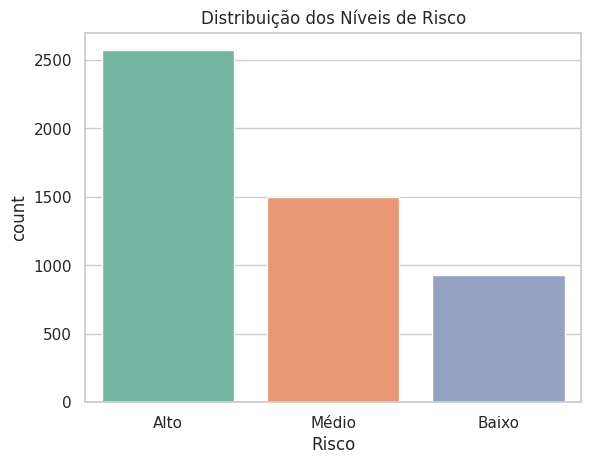

<ipython-input-12-76f832f96bb1>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Local", data=df, order=df['Local'].value_counts().index, palette="Set3")


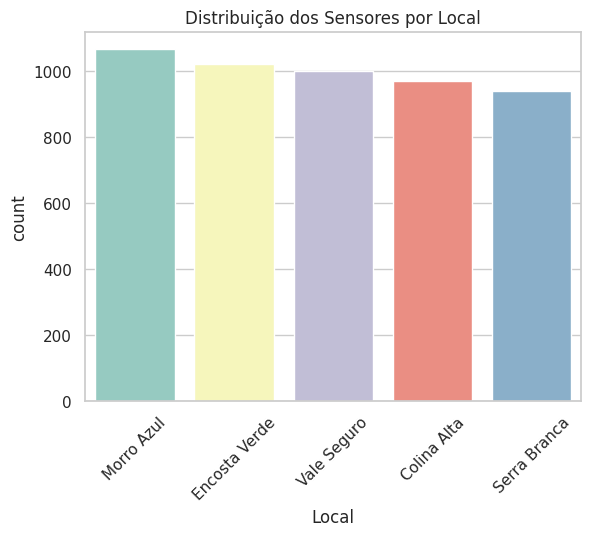

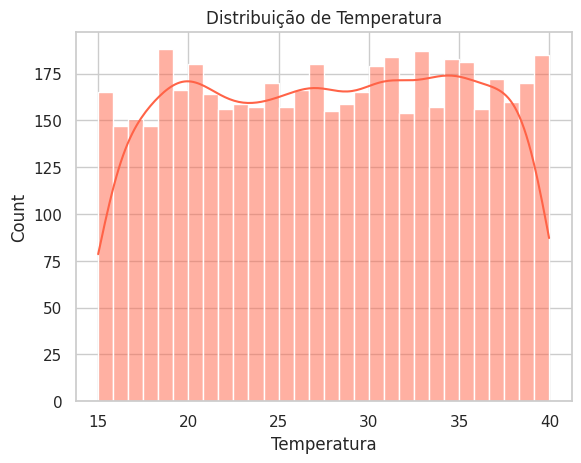

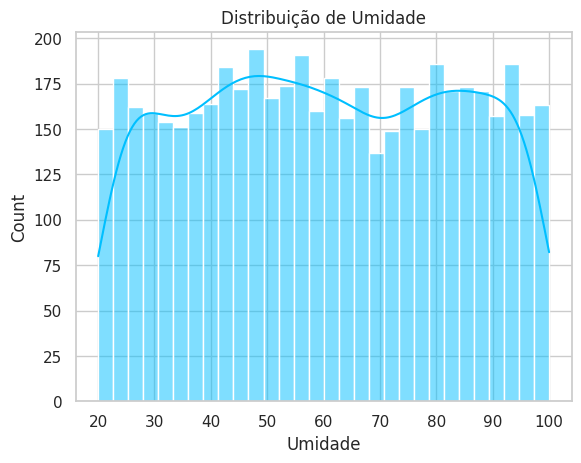

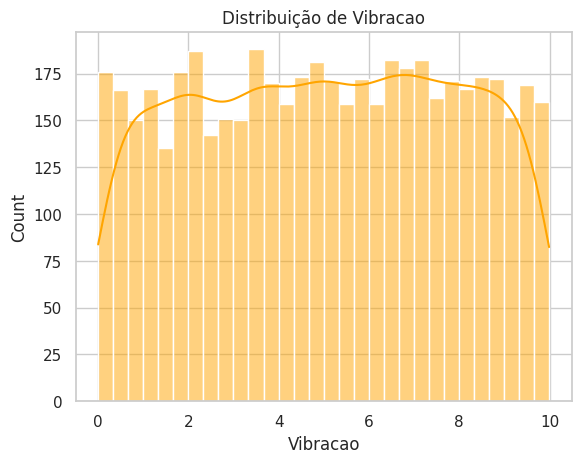

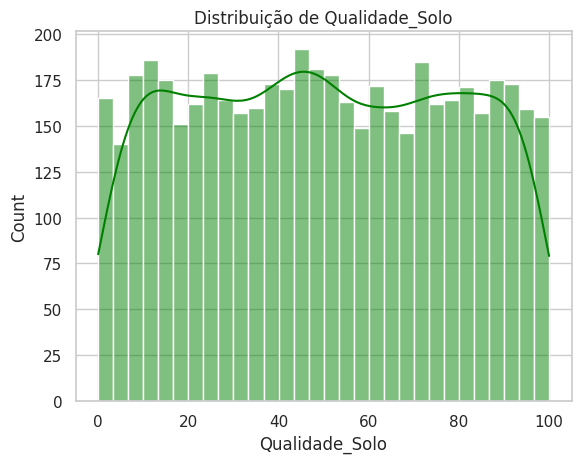

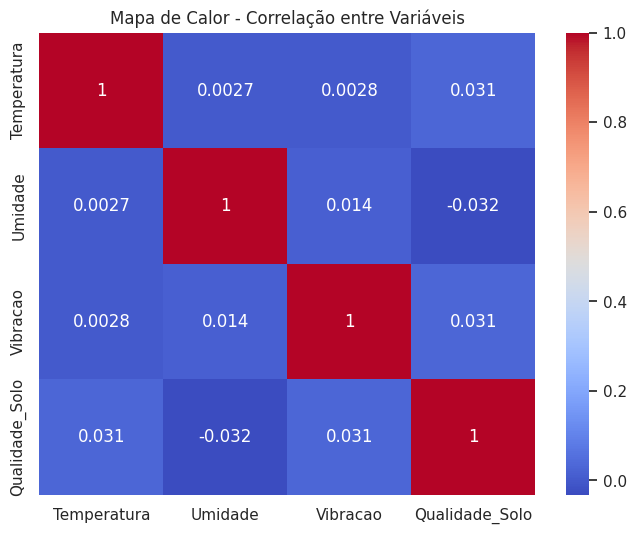

In [12]:
# Contagem dos diferentes n√≠veis de risco no dataset
sns.countplot(x="Risco", data=df, order=df['Risco'].value_counts().index, palette="Set2")
plt.title("Distribui√ß√£o dos N√≠veis de Risco")
plt.show()

# Contagem dos sensores por local
sns.countplot(x="Local", data=df, order=df['Local'].value_counts().index, palette="Set3")
plt.title("Distribui√ß√£o dos Sensores por Local")
plt.xticks(rotation=45)
plt.show()

# Features num√©ricas para an√°lise
features = ["Temperatura", "Umidade", "Vibracao", "Qualidade_Solo"]
colors = ["tomato", "deepskyblue", "orange", "green"]

# Histogramas com KDE para cada feature
for feature, color in zip(features, colors):
    sns.histplot(df[feature], bins=30, kde=True, color=color)
    plt.title(f"Distribui√ß√£o de {feature}")
    plt.show()

# Mapa de calor para correla√ß√£o entre vari√°veis num√©ricas
plt.figure(figsize=(8,6))
sns.heatmap(
    df[["Temperatura", "Umidade", "Vibracao", "Qualidade_Solo"]].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Mapa de Calor - Correla√ß√£o entre Vari√°veis")
plt.show()

# **Fase 5: Machine Learning - Classifica√ß√£o de Risco**

üéØ Acur√°cia do modelo: 0.9987

Relat√≥rio de classifica√ß√£o:

              precision    recall  f1-score   support

        Alto       1.00      1.00      1.00       787
       Baixo       1.00      1.00      1.00       289
       M√©dio       1.00      1.00      1.00       424

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



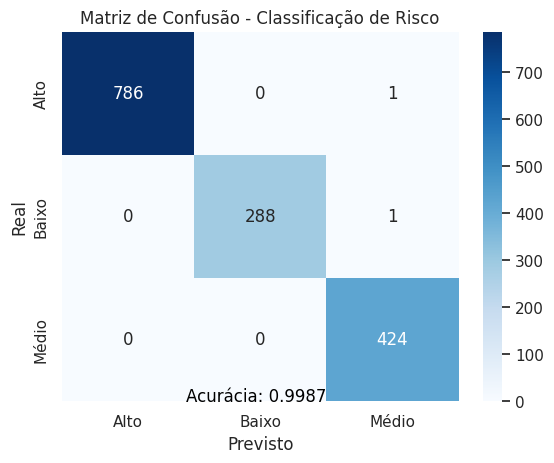

In [10]:
# Codificar vari√°veis categ√≥ricas
le_local = LabelEncoder()
le_risco = LabelEncoder()

df["Local_Enc"] = le_local.fit_transform(df["Local"])
df["Risco_Enc"] = le_risco.fit_transform(df["Risco"])

X = df[["Local_Enc", "Temperatura", "Umidade", "Vibracao", "Qualidade_Solo"]]
y = df["Risco_Enc"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = XGBClassifier(eval_metric="mlogloss")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Acur√°cia do modelo: {acc:.4f}")

print("\nRelat√≥rio de classifica√ß√£o:\n")
print(classification_report(y_test, y_pred, target_names=le_risco.classes_))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=le_risco.classes_, yticklabels=le_risco.classes_
)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confus√£o - Classifica√ß√£o de Risco")

plt.text(
    cm.shape[1] - 1, cm.shape[0],
    f"Acur√°cia: {acc:.4f}",
    fontsize=12, color='black', ha='right'
)

plt.show()

#**Fase 6: Exporta√ß√£o dos Dados**

In [11]:
df.to_csv("geoguardian_dataset.csv", index=False)
print("üíæ Dataset salvo como 'geoguardian_dataset.csv'.")

üíæ Dataset salvo como 'geoguardian_dataset.csv'.


# **Conclus√£o do Projeto**


**O problema que o GeoGuardian resolve √© a dificuldade de identificar, com anteced√™ncia, eventos cr√≠ticos como enchentes, deslizamentos e rompimentos de barragens em meio a uma grande quantidade de dados coletados pelos sensores IoT. Sem uma an√°lise preditiva eficaz, muitos alertas ficam ‚Äúperdidos‚Äù ou geram falsos positivos, prejudicando a capacidade das equipes de resposta de priorizar os riscos reais. Isso gera atrasos na tomada de decis√£o, aumenta o risco para as comunidades e reduz a efici√™ncia das a√ß√µes preventivas e emergenciais. A an√°lise preditiva do GeoGuardian transforma dados brutos em insights precisos, permitindo identificar padr√µes e antecipar desastres, o que facilita a resposta r√°pida e a prote√ß√£o das pessoas e do meio ambiente.**


---

**E √© com est√° analise bem elaborada que desenvolvemos uma simula√ß√£o completa de um sistema inteligente de seguran√ßa e monitoramento para o nosso projeto GeoGuardian, contemplando as seguintes etapas:**


* Gera√ß√£o e simula√ß√£o de dados, criando um dataset robusto que representa alertas e eventos de seguran√ßa, com vari√°veis como localiza√ß√£o, tipo de alerta, n√≠vel de risco, hor√°rio, dispositivo e status do alerta.

* An√°lise explorat√≥ria dos dados, que possibilitou entender os padr√µes de risco, identificar as localiza√ß√µes mais cr√≠ticas, hor√°rios de maior incid√™ncia de alertas e os tipos de amea√ßas mais recorrentes.

* Constru√ß√£o e avalia√ß√£o de modelos de Machine Learning, capazes de prever o n√≠vel de risco de um alerta, com uma acur√°cia expressiva (pr√≥xima de 99,9%), utilizando algoritmos como Decision Tree, Random Forest e XGBoost, para auxiliar na prioriza√ß√£o de respostas r√°pidas em casos cr√≠ticos.

* Valida√ß√£o dos insights, utilizando visualiza√ß√µes estrat√©gicas e m√©tricas que comprovam a efici√™ncia do modelo e a relev√¢ncia dos dados gerados.



---


**Por meio dessa an√°lise tamb√©m, podemos ver como a intelig√™ncia de dados pode ser aplicada para potencializar sistemas de seguran√ßa, possibilitando:**

* Prever situa√ß√µes de risco em tempo real, com base no hist√≥rico de alertas e caracter√≠sticas dos eventos.

* Identificar padr√µes cr√≠ticos, como locais mais perigosos, tipos de amea√ßas recorrentes e hor√°rios de maior vulnerabilidade.

* Otimizar a gest√£o de recursos de seguran√ßa, alocando melhor as equipes e dispositivos em √°reas e hor√°rios de maior risco.

* Aumentar a efici√™ncia na resposta a incidentes, priorizando alertas de alto risco antes que se tornem eventos cr√≠ticos.


---


**Al√©m disso, o projeto √© escal√°vel e aplic√°vel em ambientes reais, podendo ser adaptado para cidades inteligentes, empresas de seguran√ßa, monitoramento de patrim√¥nios e at√© prote√ß√£o de dados f√≠sicos e digitais.**


